OldIdea: The idea is to open the file and then try out linear and tfim schedule.

New Idea: build pipeline (Analyse fluctuation)

Points of weak link:
* Picking the spin
* tau list
* coeff to scale g-> metric to get the curve, rather than linear.
    * Use Christoffel symobol to find the magnitude
* p for qaoa
* reverse bitstring ?: QAOA reverses

As of now this notebook has the pipeline until finding the schedule. Annealing with these schedules are done in another notebook under the name: adaptive_annealing

In [1]:
using HDF5
using Printf
using AdaptiveQuantumAnnealing
using QAOA, Arpack
using PyPlot, SpinFluctuations, LinearAlgebra, Interpolations, DelimitedFiles
using  ForwardDiff, Statistics
using DifferentialEquations, Printf
# PyPlot.plt.style.use("./paper.mplstyle")
using PyCall, DataFrames

PyPlot.plt.style.use("~/paper.mplstyle") 

qp = pyimport("qutip")
np = pyimport("numpy")
rc("text", usetex=true)

┌ Warning: Error requiring `KrylovKit` from `LinearSolve`
│   exception = (LoadError("/home/ubuntu/.julia/packages/LinearSolve/qCLK7/ext/LinearSolveKrylovKitExt.jl", 1, ArgumentError("Package LinearSolve does not have KrylovKit in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have LinearSolve checked out for development and have\n  added KrylovKit as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with LinearSolve")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f47ca55c9fe, Ptr{Nothing} @0x00007f47ca55cc26, Ptr{Nothing} @0x00007f47e1488b2d, Ptr{Nothing} @0x00007f47e14c5418, Ptr{Nothing} @0x00007f47e14c743b, Ptr{Nothing} @0x00007f47e14c6bc7, Ptr{Nothing} @0x00007f47e14c6f50, Ptr{Nothing} @0x00007f47e14c81da, Ptr{Nothing} @0x00007f47cca04d41, Ptr{Nothing} @0

# Opening the instance

In [2]:
# # File edited by Tim, with the exact EVs; few handpicked instances of mirkarimi

# PATH = "/home/ubuntu/Archives/data/MAX2SAT/mirkarimi/"
# idx = 30#77#30#20#1988#9 # 21 # 19
# filename = PATH * @sprintf("HDF5/max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.h5", idx, N, num_clauses)
# # h5open(filename)

# h = h5read(filename, "local_fields")
# J_mat = h5read(filename, "coupling_matrix");

# λ = h5read(filename, "exact_ARPACK_LM_eigvals");


In [3]:
# # SK instance- Recieved via email from Tim
# a = "/home/ubuntu/.julia/dev/AdaptiveQuantumAnnealing/instances/random_SK_instance_N_9_seed_131412.h5"

# J_mat  = h5read(a,"J")
# mf_problem = Problem(2^12,J_mat);
# N = mf_problem.num_qubits

In [4]:
# Extra.csv: Mirkarimi raw data
# If you are running this, keep in mind you do not have the exact arpack stored in lambda above, but nonetheless we redo this calculation below
# ms_filename =  "khdzusjsapqkkrbpjlknwsbxdbijax"
# ms_filename =  "enztqatnbllpqrwpsakvaojconsumj"
# ms_folder_path = "/home/ubuntu/Archives/data/MAX2SATQuantumData/Mirkarimi_ComparingHardness/instances_typical/"
# ms_folder_path = "/home/ubuntu/Archives/data/MAX2SAT/crosson/"
# ms_filename = string(0)
# ms_file_path =  ms_folder_path * ms_filename * ".m2s"
# N = 10
# gap_loc = 0

In [5]:
# # To get the J and h for the mirkarimi raw
# types_to_values = Dict("type_1" => (1, 1, 1), "type_2" => (1, -1, -1), "type_3" => (-1, 1, -1), "type_4" => (-1, -1, 1))
# function get_clause_type_from(pair_of_unary_logical_connectives)
#     mapping = Dict((1, 1) => "type_1", (1, -1) => "type_2", (-1, 1) => "type_3", (-1, -1) => "type_4")
#     mapping[pair_of_unary_logical_connectives]
# end

# rawdata = readdlm(ms_file_path)

# not_negated_1 = rawdata[:, 1]
# not_negated_2 = rawdata[:, 3]
# unary_logical_connectives = zip(not_negated_1, not_negated_2) |> collect 
# clause_types = get_clause_type_from.(unary_logical_connectives)

# vars_1 = (rawdata[:, 2] .|> Int) .+ 1
# vars_2 = (rawdata[:, 4] .|> Int) .+ 1    
# clause_vars = zip(vars_1, vars_2) .|> collect

# clause_types = get_clause_type_from.(unary_logical_connectives)

# C = zip(clause_vars, clause_types)  |> collect

# h = zeros(N)
# J = zeros(N, N)
# for c in C
#     h[c[1][1]] += -types_to_values[c[2]][1]
#     h[c[1][2]] += -types_to_values[c[2]][2]
#     J[c[1][1], c[1][2]] += -types_to_values[c[2]][3]
# end
# J_mat = J + transpose(J);

# mf_problem = Problem(0, h, J_mat);

In [6]:
# SK-Tim-RocketChat
J_mat = [0.0000 -0.3935 -0.0293 -0.1723 0.2925 0.2980 -0.0653 0.0795 0.3231; -0.3935 0.0000 0.2155 -0.1747 0.0003 -0.1460 0.3691 -0.0424 0.7848; -0.0293 0.2155 0.0000 -0.0278 0.0775 -0.0089 0.4674 0.5540 -0.1661; -0.1723 -0.1747 -0.0278 0.0000 -0.4918 -0.2860 0.7536 -0.5298 -0.2358; 0.2925 0.0003 0.0775 -0.4918 0.0000 0.4682 -0.0260 -0.0048 -0.1009; 0.2980 -0.1460 -0.0089 -0.2860 0.4682 0.0000 0.0612 0.3231 0.1912; -0.0653 0.3691 0.4674 0.7536 -0.0260 0.0612 0.0000 -0.1662 -0.2366; 0.0795 -0.0424 0.5540 -0.5298 -0.0048 0.3231 -0.1662 0.0000 -0.2560; 0.3231 0.7848 -0.1661 -0.2358 -0.1009 0.1912 -0.2366 -0.2560 0.0000]
mf_problem = Problem(0,J_mat)

Problem
  num_qubits: Int64 8
  num_layers: Int64 0
  local_fields: Array{Real}((8,)) Real[0.3231, 0.7848, -0.1661, -0.2358, -0.1009, 0.1912, -0.2366, -0.256]
  couplings: Array{Real}((8, 8)) Real[0.0 -0.3935 … -0.0653 0.0795; -0.3935 0.0 … 0.3691 -0.0424; … ; -0.0653 0.3691 … 0.0 -0.1662; 0.0795 -0.0424 … -0.1662 0.0]
  edges: Array{CartesianIndex{2}}((56,))
  driver: YaoBlocks.ConstGate.XGate X


In [7]:
# # Bulk SK instance.

# system_size = 13
# file_path = @sprintf("/home/ubuntu/Archives/data/tb_mount/N_%s/small_gaps/", string(system_size))


# # results_file = @sprintf("results_random_SK_instance_N_%s_seed_", string(system_size)) * "104147" * ".h5" 
# # seed = 10280
# seed = 1740 
# instance_file = @sprintf("random_SK_instance_N_%s_seed_", string(system_size)) * string(seed) * ".h5";


# J_mat  = h5read(file_path * instance_file,"J")
# mf_problem = Problem(2^12,J_mat);
# N = mf_problem.num_qubits


# Spectrum + Adiab. Ratio

In [8]:
# Getting the exact eignevalues
exact_times = range(0, 1, 33)

# Getting the EVs once again, because I need the eigenvectors.
eigeninfo = map(s -> (eigs(-AdaptiveQuantumAnnealing.hamiltonian(1 - s, s, mf_problem.local_fields, mf_problem.couplings), nev=100, which=:LM, maxiter=10000)), exact_times);

In [9]:
# Getting the eigenvalues sorted
λ = [vals[1] for vals in eigeninfo]
λ = reduce(hcat, λ);
λ_new = sort( λ, dims=1);

In [10]:
gap_loc = argmin(λ_new[2,:] - λ_new[1,:])/length(exact_times)

0.7878787878787878

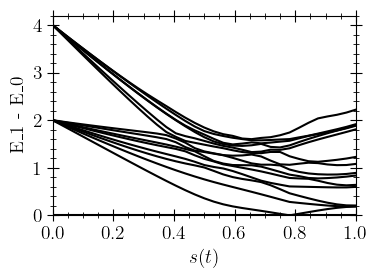

In [11]:
figure(figsize=(4, 3))
subplot(111)

for i in 1:15#size(bogo_spec)[1]
    plot(exact_times, (λ_new[i, :] .- λ_new[1, :]), "-k", ms=2)
end
xlim(0., 1.)
ylim(-0., )
xlabel(L"s(t)")
ylabel("E_{1} - E_{0}")
tight_layout()
gcf()
# savefig("/home/ubuntu/Archives/projects/Master_thesis/graphics/results/sk_instance_2/arpack_spectrum.pdf")

### Adiabatic ratio

In [12]:
N = mf_problem.num_qubits

8

In [13]:
# This is just for the lionear schedule H' = H_p - H_d

H_x = SpinFluctuations.hamiltonian(1, 0, mf_problem.local_fields, mf_problem.couplings);
H_z = SpinFluctuations.hamiltonian(0, 1, mf_problem.local_fields, mf_problem.couplings);

In [14]:
# This is for sorting the eigenvectors, because, the eigen values are sorted, the map needs to be restored
λs = [vals[1] for vals in eigeninfo]

all_eigvecs = zeros(length(exact_times), 2^(N), 5)
for k in 1:length(exact_times)
    sorting_perm = sortperm(λs[k])
    all_eigvecs[k, :, :] .= eigeninfo[k][2][:, sorting_perm[1:5]]
end


In [15]:
# Collecting the eigen vectors
gs = [all_eigvecs[k, :, 1] for k in 1:length(exact_times)]
first_ex = [all_eigvecs[k, :, 2] for k in 1:length(exact_times)]
second_ex = [all_eigvecs[k, :, 3] for k in 1:length(exact_times)];
three_ex = [all_eigvecs[k, :, 4] for k in 1:length(exact_times)];
four_ex = [all_eigvecs[k, :, 5] for k in 1:length(exact_times)];
# five_ex = [all_eigvecs[k, :, 6] for k in 1:length(exact_times)];
;

In [16]:
# The numerator overlap
overlap_01_x = [first_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_01_z = [first_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)]

overlap_02_x = [second_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_02_z = [second_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)];

overlap_03_x = [three_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_03_z = [three_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)];

overlap_04_x = [four_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_04_z = [four_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)];

# overlap_05_x = [five_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
# overlap_05_z = [five_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)];
;

In [17]:
# The minimal gap
min_gap_1 = minimum(λ_new[2, :] .- λ_new[1, :]);
min_gap_2 = minimum(λ_new[3, :] .- λ_new[1, :]);

The reason why we plot the different overlaps is to notice if there are any other excitations other than the regular one (gs->1st). We can see if we can try supressing this, as this might cause the probablity of the solution state to increase. 

"ckuzagjudgfdjroeuapzqasfazmjyb": In this instance you can see this other excitations. Although the value of the fraction is small.

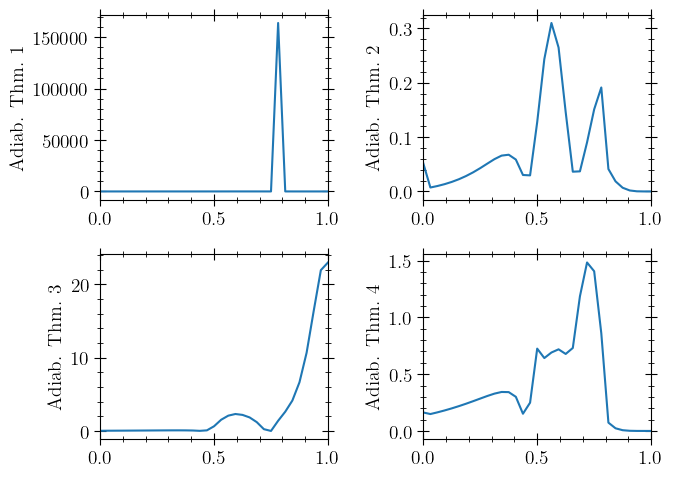

In [18]:
figure(figsize=(7, 5))
ax = subplot(221)
plot(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ ((λ_new[2, :] .- λ_new[1, :])).^2)
# plot(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ min_gap_1)
xlim(0., 1.)
# ylim(0, 5)
# ax.set_xticklabels([])
ylabel("Adiab. Thm. 1")


ax = subplot(222)
plot(exact_times, abs.(overlap_02_z .- overlap_02_x) ./ ((λ_new[3, :] .- λ_new[1, :])).^2)
# plot(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ min_gap_1)
xlim(0., 1.)
# ylim(0, 5)
# ax.set_xticklabels([])
ylabel("Adiab. Thm. 2")


ax = subplot(223)
plot(exact_times, abs.(overlap_03_z .- overlap_03_x) ./ ((λ_new[4, :] .- λ_new[1, :])).^2)
# plot(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ min_gap_1)
xlim(0., 1.)
# ylim(0, 5)
# ax.set_xticklabels([])
ylabel("Adiab. Thm. 3")


ax = subplot(224)
plot(exact_times, abs.(overlap_04_z .- overlap_04_x) ./ ((λ_new[5, :] .- λ_new[1, :])).^2)
# plot(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ min_gap_1)
xlim(0., 1.)
# ylim(0, 5)
# ax.set_xticklabels([])
ylabel("Adiab. Thm. 4")

tight_layout()

display(gcf())
close()

# MF Trajectory 08.12


In [19]:
# # MF solution trajextory 
T_final = 30000.
tol = 1e-8;
schedule(t) = t / T_final
sol = evolve_mean_field(mf_problem.local_fields, mf_problem.couplings, T_final, schedule, rtol=1e2tol, atol=tol);

In [20]:
# Finding the top area
component_dict = Dict("x" => 1, "y" => 2, "z" => 3)
component = "z"
test_data = reduce(hcat, [sol.u[k][component_dict[component], :] for k in 1:size(sol.u)[1]]);

areas = Dict()
dts = [(x[2] - x[1]) / T_final for x in zip(sol.t[1:end-1], sol.t[2:end])]
for spin_idx in 1:N
    areas[spin_idx] = sum(dts .* test_data[spin_idx, 2:end]) |> abs
end

top_idxs = [k for (k, v) in sort(areas |> collect, by=x->x[2])];
top_idx = top_idxs[1]

2

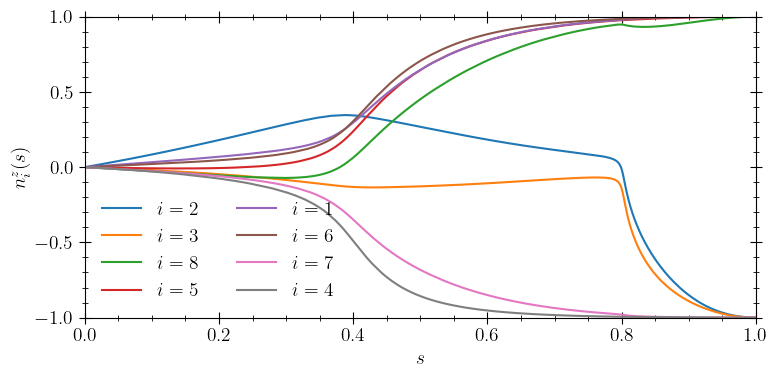

2


In [21]:
figure(figsize=(8, 4))

subplot(111)
ck = 1
for (spin_nr, _) in sort(areas |> collect, by=x->x[2])[1:N]
    if ck == 1
        ck = ck +1
        println(ck)
        plot(sol.t ./ T_final, test_data[spin_nr, :], "-", label=@sprintf("\$i=%i\$", spin_nr))#, color = "red")    
    else    
        plot(sol.t ./ T_final, test_data[spin_nr, :], "-", label=@sprintf("\$i=%i\$", spin_nr))#, color = "black")    
        
    end
end

xlim(0, 1)
ylim(-1, 1)
xlabel("\$s\$")
ylabel("\$n_i^z(s)\$")
legend(frameon=false, ncol=2)

tight_layout()
# savefig("/home/ubuntu/Archives/projects/Master_thesis/graphics/results/sk_instance_2/spin_trajectory.pdf")
display(gcf())

# GF fluctuation ii

In [22]:
npts = 2^12
# npts = 8192
coarse_times = range(0, 1, npts + 1);
lyapunov_parameters = LyapunovParameters(T_final, npts, tol, tol);

In [23]:
# This gives the action matrix(20X20) for the gaussian fluctuation - 2048 points 
mf_sol, stat_GF = statistical_green_function(mf_problem, lyapunov_parameters);

In [24]:
# Refer to the eq. 11.20 from Altman, Retard green functions 
flucs = k -> (real.(1.0im .* diag(stat_GF[k])[1:mf_problem.num_qubits]) .- 1.0) ./ 2;
all_flucs = reduce(hcat, map(flucs, 1:npts+1));

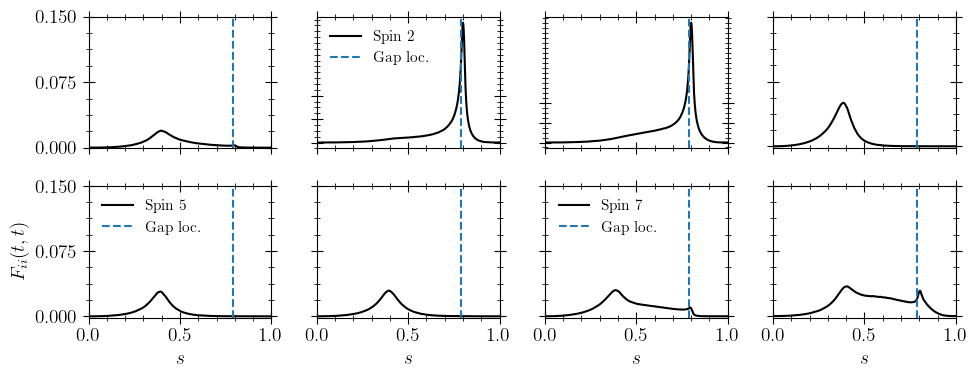

In [25]:
# N =10
# Set figure size
figure(figsize=(10, 4))

# Define the y-axis range and tick positions
ylims = (0, 0.15)
ytick_positions = [0, 0.075, 0.15]  # Manually specify the tick positions

# Plotting loop
for i in 1:(N ÷ 2)
    ax = subplot(2, (N ÷ 2), i)
    c = "k"
    plot(coarse_times, smoothen(all_flucs[i, :], coarse_times), c=c, label = "Spin $i", linewidth=1.5)
    axvline(gap_loc, ls="--", color="C0", label = "Gap loc.")
    xlim(0., 1)
    ax.set_xticklabels([])
    yticks(ytick_positions)  # Set y-axis ticks
    if i > 1
        ax.set_yticklabels([])
    end
    if i == 2
        legend(loc="upper left", fontsize=11)
    end
end

# Plotting loop for the second row
for i in ((N ÷ 2) + 1):N
    ax = subplot(2, (N ÷ 2), i)
    c = "k"
    plot(coarse_times, smoothen(all_flucs[i, :], coarse_times), c=c, label = "Spin $i", linewidth=1.5)
    axvline(gap_loc, ls="--", color="C0", label = "Gap loc.")
    xlim(0., 1)
    yticks(ytick_positions)  # Set y-axis ticks
    xlabel(L"$s$", fontsize=14)
    if i > ((N ÷ 2) + 1)
        ax.set_yticklabels([])
    else
        ax.set_ylabel(L"$F_{ii}(t, t)$", fontsize=14)
    end    
    if i == 5 || i == 7
        legend(loc="upper left", fontsize=11)
        
    end
end

# Tight layout
tight_layout()



# Display figure
display(gcf())
# savefig("/home/ubuntu/Archives/projects/Master_thesis/graphics/results/sk_instance_2/fluctuations.pdf")


In [26]:
cut_solution(x) = sol.(x .* sol.t[end]); # Just converts the domain from [0,30k]->[0,1]
nx_coarse = hcat([matrix[1, :] for matrix in cut_solution(coarse_times)]...); # Extracting the individual spin from the sol
ny_coarse = hcat([matrix[2, :] for matrix in cut_solution(coarse_times)]...);
nz_coarse = hcat([matrix[3, :] for matrix in cut_solution(coarse_times)]...);

# Scaling the fluctuation
scaled_flucs(scale_factor, spin_nr) = smoothen(scale_factor.^2 .* all_flucs[spin_nr, :], coarse_times, navg=128) # gives the scaled flucs.

scaled_flucs (generic function with 1 method)

In [27]:
trajectory_max_frus = nz_coarse[top_idx,:].^2;

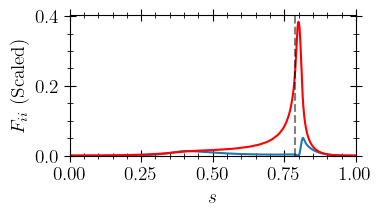

In [28]:
# Beautification
# Set figure size
figure(figsize=(4, 4))

# Calculate scale factor
scale_factor = (1 .+ abs.(complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse)).^2)

# Plot scaled fluctuations
subplot(212)
plot(coarse_times,  1 .* scaled_flucs(scale_factor, top_idx) .* trajectory_max_frus)
plot(coarse_times, smoothen(all_flucs[top_idx, :], coarse_times), c="red", label = "Spin %i", linewidth=1.5)
# plot(coarse_times, smoothen(all_flucs[2, :], coarse_times), c="red", label = "Spin 2 ", linewidth=1.5)
axvline(gap_loc, ls="--", c="k", alpha=0.5)
xlim(0, 1)
ylim(0, )  # Adjust ylim as needed
xlabel("\$s\$")
ylabel("\$F_{ii}\$ (Scaled)")
# title("\$i = \$", fontsize=14)  # Set subplot title with reduced font size

# Tight layout
tight_layout()

# Display figure
display(gcf())


In [29]:
# Gaussian with a peak in at the gap location
function generate_gaussian(peak_position)
    σ = 0.05  # SD- adjust
    # A = 1 / exp(-0.5 * ((0.5 - peak_position) / σ)^2)  # Amplitude to ensure f(0) = f(1) = 0 # Not sure wether if this does that 

    gaussian(x) = 4 * exp(-0.5 * ((x - peak_position) / σ)^2)
    return gaussian
end

generate_gaussian (generic function with 1 method)

In [30]:
scaled_metric = 1 .* scaled_flucs(scale_factor, top_idx) .* trajectory_max_frus
normed_scaled_metric = 4 .* scaled_metric ./ maximum(scaled_metric);
Chi_new_metric = normed_scaled_metric;

In [31]:
# This was for the case, when the scaled fluctuations were not used.
# # Chi_new_metric = scaled_flucs(scale_factor, top_idx);
# Chi_new_metric = scaled_flucs(scale_factor, top_idx) .* trajectory_max_frus
# # Chi_new_metric_norm = Chi_new_metric ./ maximum(Chi_new_metric);
# Chi_new_metric_norm = generate_gaussian(argmax(Chi_new_metric) / length(coarse_times)).(coarse_times); # gives a gaussian
# # Chi_new_metric_norm = Chi_new_metric_norm ./ maximum(Chi_new_metric_norm);# This should normalise it to max height one??
# Chi_new_metric = copy(Chi_new_metric_norm);

In [39]:
# # Set figure size
# figure(figsize=(10, 3))

# # Calculate scale factor
# scale_factor = 1 .+ abs.(complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse)).^2

# # Plot scaled fluctuations on the left
# subplot(1, 2, 1)
# plot(coarse_times, scaled_flucs(scale_factor, top_idx))
# axvline(gap_loc, ls="--", c="k", alpha=0.5, label="Gap Position")
# xlim(0, 1)
# ylim(0, )  # Adjust ylim as needed
# xlabel("\$s\$")
# ylabel("\$F_{ii}\$ (Scaled)")
# title("\$i = 2\$", fontsize=10)  # Set subplot title with reduced font size
# legend() 

# # Plot Chi_new_metric_norm on the right
# subplot(1, 2, 2)
# plot(coarse_times, Chi_new_metric_norm)
# axvline(gap_loc, ls="--", c="k", alpha=0.5)
# xlim(0, 1)
# ylim(0, )  # Adjust ylim as needed
# xlabel("\$s\$")
# # ylabel("Metric")
# title("Derived metric", fontsize=10)  # Set subplot title with reduced font size

# # Tight layout
# tight_layout()

# # Display figure
# display(gcf())
# # savefig("/home/ubuntu/Archives/projects/Master_thesis/graphics/results/sk_instance_2/schedule.pdf")

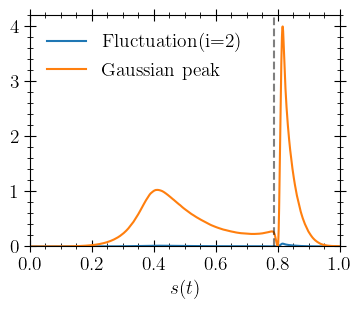

In [33]:
figure(figsize = (4,3))

plot(coarse_times, scaled_flucs(scale_factor, top_idx) .* trajectory_max_frus, label = @sprintf("Fluctuation(i=%i)", top_idx))
plot(coarse_times, Chi_new_metric, label = " Gaussian peak") # Scaled flucs or Gaussian metric.
axvline(gap_loc, ls="--", c="k", alpha=0.5)
# axvline(argmax(Chi_new_metric) / length(coarse_times), linestyle = "--", color = "grey", label = "Peak loc.")
legend()
xlim(0, 1)
ylim(0,)  # Adjust ylim as needed
xlabel("\$s(t)\$")
# ylabel("\$F_{ii}\$ (Scaled)")

display(gcf())
# savefig("/home/ubuntu/Archives/projects/Master_thesis/graphics/results/sk_instance_2/gaussian_metric.pdf")

### Schedule

In [34]:
T_f_in = 7000
taulist = range(0, T_f_in, trunc(Int, 10* T_f_in)) # for the annealing

0.0:0.10000142859183703:7000.0

In [35]:
g_new = linear_interpolation(coarse_times, Chi_new_metric)
g_feed = x-> 1 * g_new(x); # This multiplication with a scalar is to enhance the flatness at the gap region

In [36]:
adaptive_schedule_parameters = AdaptiveScheduleParameters(taulist[end], RK4(), [0.0, 1.], 10000, 20, 1e-7, 1e-9)
adaptive_schedule = solve_boundary_value_problem(g_feed, adaptive_schedule_parameters);

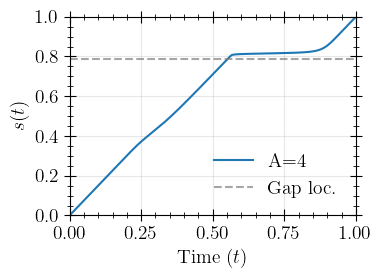

In [37]:
figure(figsize=(4, 3))

# Plot the schedule
plot(taulist ./ taulist[end], adaptive_schedule.(taulist), label="A=4", linewidth=1.5)

# Add a vertical line at the gap location
axhline(gap_loc, ls="--", c="gray", alpha=0.7, label="Gap loc.")

# Set limits and labels
# xlim(taulist[1], taulist[end])
xlim(0, 1)
xlabel("Time (\$t\$)")
ylabel("\$s(t)\$")
ylim(0, 1)

# Add legend with improved formatting
legend(frameon=false)#, loc = "upper left")

# Add gridlines for better readability
grid(alpha=0.3)

# Tight layout
tight_layout()

# Display figure
display(gcf())

# savefig("/home/ubuntu/Archives/projects/Master_thesis/graphics/results/sk_instance_2/schedule_3.pdf")


### Subtracting background

How about subtracting the average of all other than the best. more like removeng noise from other spins. 
**We no longer do this**

In [5]:
# # Why are we subtracting the background noise. Does it even make sense to do this. 
# # We can see that by plotting after subtracting the mean of the fluctiation.b
# mean_flucs =  smoothen(normalize(mean(eachrow(all_flucs))), coarse_times)
# all_flucs_smooth = mapslices(x->smoothen(x, coarse_times), all_flucs; dims=2 )
# all_flucs_bg_rmv = mapslices(x -> x - mean_flucs, all_flucs_smooth; dims =2 );

In [6]:
# mean_flucs =  smoothen(mean(eachrow(all_flucs)), coarse_times)
# all_flucs_smooth = mapslices(x->smoothen(x, coarse_times), all_flucs; dims=2 )
# all_flucs_bg_rmv = mapslices(x -> x - mean_flucs, all_flucs_smooth; dims =2 );

In [7]:
# figure(figsize=(8, 3))
# # ylims = (-0.0,0.5) #(-0.0, 0.1) # 0.25
# for i in 1:(N)÷2
#     ax = subplot(2, (N)÷2, i)
#     c = "k"
#     plot(coarse_times, all_flucs_bg_rmv[i,:], label=@sprintf("\$i=%s\$", string(i)), c=c)
#     axvline(gap_loc, ls = "--")
#     xlim(0., 1.)
#     ax.set_xticklabels([])
#     ylim(ylims...)
#     if i > 1
#         ax.set_yticklabels([])
#     end
#     legend(frameon=false, ncol=2, handlelength=0)
# end

# ax = subplot(2, (N)÷2, 1)
# ax.set_ylabel("\$F_{ii}(t, t)\$")

# for i in (N)÷2+1:N
#     ax = subplot(2, (N)÷2, i)
#     c = "k"
    
#     plot(coarse_times, all_flucs_bg_rmv[i,:], label=@sprintf("\$i=%s\$", string(i)), c=c)
#     axvline(gap_loc, ls = "--")
#     xlim(0., 1.)
#     ylim(ylims...)
#     if i > (N)÷2+1
#         ax.set_yticklabels([])
#     end    
#     xlabel("\$s\$")    
#     legend(frameon=false, ncol=2, handlelength=0)
# end

# ax = subplot(2, (N)÷2, (N)÷2 + 1)
# ax.set_ylabel("\$F_{ii}(t, t)\$")

# tight_layout()
# display(gcf())
# close()
# # savefig("../plots/" * @sprintf("fluctuations_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
# # PythonPlot.close();

# Magnetisation 
Forget this for now. The plan was to use this as a normalisation factor for the fluctuation. 

In [8]:
# An alternative to the n_vals approach. Rather use the ODE solution "sol" directly. sol[1,N,:] (A special method to access the solution) refer to ODE documentation
# https://docs.sciml.ai/DiffEqDocs/stable/basics/solution/

# nx_vals = n_vals("x", sol_u)
# nx_coarse = sol.u[]
# sol[1,N,:] 
# reduce(hcat,[sol[3,k,:] for k in 1:N])
# [sol[3,k,:] for k in 1:N]


In [9]:
# cut_sol = sol.(coarse_times .* sol.t[end]); # When we don't need the detailed solution from mf, rather the solution for a coarser time discretisaiton.
# # define a new coarse time, if you want shorter vectors

# third_rows_matrix_mag = hcat([matrix[3, :] for matrix in cut_sol]...); # Gives the z component of spin for all spins across entire time period of coarse times

In [10]:
# S_val = reduce(hcat,[third_rows_matrix_mag[k,:] for k in 1:N]) # Picking the z componenet
# allmag_temp = reduce(hcat,[dot(mf_problem.couplings[i,:] , S_val[j,:]) for j in 1:size(S_val)[1]] for i in 1:N);# Calculate m for all times
# mag = (allmag_temp .+ transpose(mf_problem.local_fields));

In [11]:
# This one is not the smooth and cut_short one. run the above code

# S_val = reduce(hcat,[sol[3,k,:] for k in 1:N]) # Picking the z componenet
# allmag_temp = reduce(hcat,[dot(mf_problem.couplings[i,:] , S_val[j,:]) for j in 1:size(S_val)[1]] for i in 1:N);# Calculate m for all times
# mag = (allmag_temp .+ transpose(mf_problem.local_fields));

In [12]:
# top_idx = 2

In [13]:
# figure(figsize=(4, 2))


# ax = subplot(111)
# for spin_nr in 1:N
#     plot(coarse_times, mag[:,spin_nr], "-", c="k")#,label=@sprintf("\$i=%i\$", spin_nr))    
# end
# plot(coarse_times, mag[:,top_idx], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
# xlim(0.0, 1)
# # ylim(-1e-3, 1e-3)
# xlabel("s")
# ylabel("\$m_i(s)\$")
# legend(frameon=false)


# tight_layout()
# display(gcf())
# # savefig("../plots/" * @sprintf("mean_field_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
# # PythonPlot.close();

# Scaling fluctuation using |Z|2
Scaling the fluctuation using |Z|^2. This section is no longer needed as we do the scaling already in one of the previous sections.

In [40]:
top_idx = 2

2

In [41]:

cut_solution(x) = sol.(x .* sol.t[end]);
nx_coarse = hcat([matrix[1, :] for matrix in cut_solution(coarse_times)]...);
ny_coarse = hcat([matrix[2, :] for matrix in cut_solution(coarse_times)]...);
nz_coarse = hcat([matrix[3, :] for matrix in cut_solution(coarse_times)]...);

scaled_flucs(scale_factor, spin_nr) = smoothen(scale_factor.^2 .* all_flucs[spin_nr, :], coarse_times, navg=128)

scaled_flucs (generic function with 1 method)

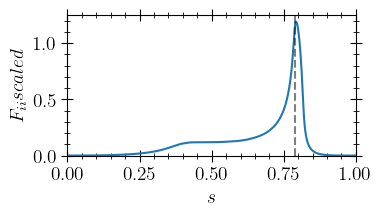

In [42]:
figure(figsize=(4, 4))


subplot(212)
scale_factor = 1 .+ abs.(complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse)).^2

plot(coarse_times, scaled_flucs(scale_factor, top_idx))# .* plot_func(abs.(mag[:,top_idx])))

# smoothen(map(x -> x[2] - x[1], zip(scaled_flucs(scale_factor, top_idxs[i])[1:end-1], scaled_flucs(scale_factor, top_idxs[i])[2:end])) ./ suscept_denom(top_idxs[i]),


axvline(gap_loc, ls="--", c="k", alpha=0.5)
xlim(0, 1)
ylim(0, )
xlabel("\$s\$")
ylabel("\$ F_{ii} scaled \$")

tight_layout()
display(gcf())
# PythonPlot.close();

In [43]:
# Gaussian with a peak in at the gap location
function generate_gaussian(peak_position)
    σ = 0.05  # SD- adjust
    # A = 1 / exp(-0.5 * ((0.5 - peak_position) / σ)^2)  # Amplitude to ensure f(0) = f(1) = 0

    gaussian(x) = 1 * exp(-0.5 * ((x - peak_position) / σ)^2)
    return gaussian
end

generate_gaussian (generic function with 1 method)

In [44]:
# argmax(Chi_new_metric) / length(coarse_times)

In [45]:
Chi_new_metric = scaled_flucs(scale_factor, top_idx);
# Chi_new_metric_norm = Chi_new_metric ./ maximum(Chi_new_metric);
Chi_new_metric_norm = generate_gaussian(argmax(Chi_new_metric) / length(coarse_times)).(coarse_times);
Chi_new_metric_norm = Chi_new_metric_norm ./ maximum(Chi_new_metric_norm);
Chi_new_metric = copy(Chi_new_metric_norm);

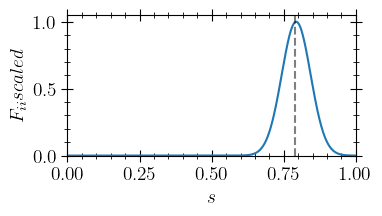

In [46]:
figure(figsize=(4, 4))


subplot(212)


# plot(coarse_times, generate_gaussian(argmax(Chi_new_metric) / length(coarse_times)).(coarse_times))# .* plot_func(abs.(mag[:,top_idx])))
plot(coarse_times, Chi_new_metric_norm)# .* plot_func(abs.(mag[:,top_idx])))
axvline(gap_loc, ls="--", c="k", alpha=0.5)
xlim(0, 1)
ylim(0, )
xlabel("\$s\$")
ylabel("\$ F_{ii} scaled \$")

tight_layout()
display(gcf())
# PythonPlot.close();

In [21]:
# # Just to study the Christoffel symbols
# g = linear_interpolation(coarse_times, Chi_new_metric);

# ∂g = x -> ForwardDiff.derivative(g, x)

# # Christoffel symbols
# Γ_AD = x -> g(x) * ∂g(x) / 2.0

# navg = 2000
# ninterp = 50000
# x = range(0., 1.0, ninterp + 1)

# Γ_shifted = linear_interpolation(x[1:end - navg + 1], SpinFluctuations.moving_average(map(Γ_AD, x), navg), extrapolation_bc=Line())
# Γ = x -> Γ_shifted(x - (navg - 1) / 2ninterp)
     